# Autoencoder Recommendation System

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from time import time
from collections import Counter
import ast

import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision 
import torch.utils.data as data
import torch.distributions as dist
import tqdm

## Data Preparation

In [76]:
df_books = pd.read_csv('books_autorec.csv')
df_books.sort_values(by='ratings_count', ascending=False, inplace=True)
Books_number = 2000
df_books = df_books.iloc[:Books_number]
df_books['goodreads_book_id'] = df_books['goodreads_book_id'].astype(int)
book_ids = df_books['goodreads_book_id']

In [77]:
df = pd.read_csv("books_autorec.csv")
df_ratings = pd.read_csv("ratings_autorec.csv")

modified_df_ratings = df_ratings.merge(
    df[['goodreads_book_id']], 
    left_on='book_id', 
    right_on='goodreads_book_id', 
    how='left'
)

# create dictionary with user and ratings
sparse_users = {}
for user_id, group in modified_df_ratings.groupby('user_id'):
    modified_books_ratings = group[['book_id', 'rating']].values.tolist()
    sparse_users[user_id] = modified_books_ratings

filter_users = {
    user: [triplet for triplet in triplets if triplet[0] in book_ids]
    for user, triplets in sparse_users.items()
}
filter_users = {user: triplets for user, triplets in filter_users.items() if triplets}
#user taken
taken_users = 50000
filter_users = sorted(filter_users.items(), key=lambda x: len(x[1]), reverse=True)[:taken_users]
filter_users = dict(filter_users)

In [78]:
mapping_pos_to_books = dict(zip(range(Books_number), book_ids))
mapping_books_to_pos = dict(zip(book_ids,range(Books_number)))
mapping_pos_to_users = dict(zip(range(taken_users), filter_users.keys()))
mapping_users_to_pos = dict(zip(filter_users.keys(),range(taken_users)))

In [79]:
n_books = len(mapping_books_to_pos)
user_vectors = []
for user_id, book_rating in filter_users.items():
    vector = np.zeros(n_books)  # initialize vector with zeros

    for book_id, rating in book_rating:
        if book_id in mapping_books_to_pos:  # if book_id is in the mapping
            index = mapping_books_to_pos[book_id]
            vector[index] = rating  # insert rating in the correct position

    user_vectors.append(vector)
    
print("Number of Users", len(user_vectors))
print("Number of Books", len(user_vectors[0]))
for i in range(len(user_vectors)):
    user_vectors[i] = [0 if elem < 4 else 1 for elem in user_vectors[i]]
print("Example of a user: ", user_vectors[0][:20])
df_input_data = pd.DataFrame(user_vectors)

Number of Users 48939
Number of Books 2000
Example of a user:  [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]


In [80]:
def compute_item_weights(df_input_data, weight_strategy='inverse_log'):
    item_review_counts = (df_input_data != 0).sum(axis=0)  # Conta recensioni per libro

    if weight_strategy == 'inverse':
        item_weights = 1.0 / (item_review_counts + 1)
    elif weight_strategy == 'inverse_log':
        item_weights = 1.0 / np.log(item_review_counts + 2)
    elif weight_strategy == 'inverse_sqrt':
        item_weights = 1.0 / np.sqrt(item_review_counts + 1)
    else:
        raise ValueError("Invalid weight strategy")

    item_weights = item_weights / item_weights.mean()

    print(f"Item weights stats:")
    print(f"  Min weight: {item_weights.min():.4f}")
    print(f"  Max weight: {item_weights.max():.4f}")
    print(f"  Mean weight: {item_weights.mean():.4f}")
    print(f"  Std weight: {item_weights.std():.4f}")

    return torch.tensor(item_weights.values, dtype=torch.float32)

item_weights = compute_item_weights(df_input_data, weight_strategy='inverse_log')

Item weights stats:
  Min weight: 0.0731
  Max weight: 1.0356
  Mean weight: 1.0000
  Std weight: 0.1793


## Clustering

In [81]:
def string_to_list(stringa):
    lista = [elemento.strip() for elemento in stringa.split(",")]
    for i, element in enumerate(lista):
        lista[i] = element.strip('[').strip(']').strip('\'')
    return lista

df_books['tags_list'] = df_books['tags_list'].apply(string_to_list)

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df_books['tags_string'])

In [83]:
from sklearn.cluster import KMeans

k = 8
kmeans_model = KMeans(n_clusters=k, random_state=3, max_iter=1000, n_init=10)
df_books['cluster'] = kmeans_model.fit_predict(X)

In [84]:
cluster_counts = df_books['cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    print(f"Cluster {cluster_id}: {count} elements")

Cluster 0: 247 elements
Cluster 1: 264 elements
Cluster 2: 318 elements
Cluster 3: 157 elements
Cluster 4: 269 elements
Cluster 5: 474 elements
Cluster 6: 56 elements
Cluster 7: 215 elements


In [85]:
def print_top_tags_per_cluster(df, top_n=20):

    for cluster_id in sorted(df['cluster'].unique()):
        tags = df[df['cluster'] == cluster_id]['tags_list'].explode()
        tag_counts = Counter(tags)
        most_common = tag_counts.most_common(top_n)
        print(f"\nCluster {cluster_id}:")
        for tag, count in most_common:
            print(f"  {tag}")

In [86]:
print_top_tags_per_cluster(df_books, top_n=10)


Cluster 0:
  sci-fi-fantasy
  fantasy
  favorites
  fiction
  books-i-own
  currently-reading
  library
  owned
  owned-books
  favourites

Cluster 1:
  owned
  owned-books
  books-i-own
  library
  currently-reading
  to-buy
  favorites
  default
  my-library
  non-fiction

Cluster 2:
  fantasy
  owned
  fiction
  books-i-own
  favorites
  i-own
  currently-reading
  library
  series
  favourites

Cluster 3:
  mystery
  favorites
  mystery-thriller
  kindle
  ebook
  fiction
  books-i-own
  owned-books
  currently-reading
  thriller

Cluster 4:
  fiction
  favorites
  literature
  books-i-own
  owned
  my-books
  to-buy
  default
  adult
  my-library

Cluster 5:
  favorites
  fiction
  owned
  books-i-own
  currently-reading
  owned-books
  library
  contemporary
  kindle
  to-buy

Cluster 6:
  fiction
  owned
  library
  my-library
  fantasy
  suspense
  adult
  my-books
  ebooks
  currently-reading

Cluster 7:
  children-s
  children-s-lit
  favorites
  kids-books
  fiction
  child

## Training

In [87]:
class Spatial_F_AE(nn.Module):
    def __init__(self,k):
        super(Spatial_F_AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(k,500),
            nn.ReLU(),
            nn.Linear(500,250),
            nn.ReLU(),
            nn.Linear(250,125),
            nn.ReLU(),
            nn.Linear(125,50),
            nn.ReLU(),
            nn.Linear(50,2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2,50),
            nn.ReLU(),
            nn.Linear(50,125),
            nn.ReLU(),
            nn.Linear(125,250),
            nn.ReLU(),
            nn.Linear(250,500),
            nn.ReLU(),
            nn.Linear(500,k),
            nn.Sigmoid(),
        )
    def forward(self,x):
        z = self.encoder(x)
        final = self.decoder(z)
        return final

In [88]:
def train(model, dataloader, criterion, optimizer, num_epochs, item_weights=None, scheduler=None, best_loss=float('inf')):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    losses = []
    model.to(device)

    # Sposta i pesi degli item sul device
    if item_weights is not None:
        item_weights = item_weights.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, batch in enumerate(dataloader):
            inputs = batch[0]
            inputs = inputs.to(device)
            recon = model(inputs)

            if item_weights is not None:
                # Calcola la loss pesata per item
                squared_errors = (recon - inputs) ** 2
                weighted_errors = squared_errors * item_weights.unsqueeze(0)  # Broadcast sui batch
                loss = weighted_errors.mean()
            else:
                # Loss standard
                loss = criterion(recon, inputs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if scheduler is not None:
                scheduler.step(loss.item())
            running_loss += loss.item()

        losses.append(running_loss / (i + 1))
        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(model.state_dict(), 'best_model.pth')
        print(f"Epoch {epoch+1}: Loss = {running_loss / (i + 1):.10f}")
    return losses

In [89]:
def loss_graph(tr_loss,n_epochs):
    plt.plot(range(n_epochs),tr_loss,label='tr_loss', c='black')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.show()

In [90]:
tensor_data = torch.tensor(df_input_data.values, dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(tensor_data)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
model = Spatial_F_AE(Books_number)

It the model is already trained and you see the best_model.pth file in the repository you can avoid retraining and run the followinc cell to sideload the weights of the model

In [91]:
# model.load_state_dict(torch.load('best_model.pth'))

Actual train of the model:

Epoch 1: Loss = 0.0018656808
Epoch 2: Loss = 0.0002055560
Epoch 3: Loss = 0.0002054906
Epoch 4: Loss = 0.0002053852
Epoch 5: Loss = 0.0002052664


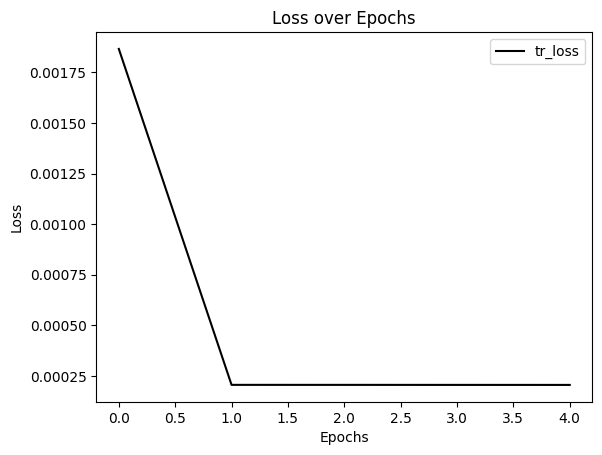

In [92]:
criterion = nn.MSELoss()
N_Epochs = 5
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

losses = train(model, dataloader, criterion, optimizer, N_Epochs, item_weights, scheduler)
loss_graph(losses, N_Epochs)

## Find Recommendations

In [98]:
def recommendations(user, model, n=25):
    model.eval()
    recon = model(user)

    recon_masked = recon.clone()
    recon_masked[user != 0] = float('-inf')  # Escludi libri già valutati

    _, new_books = torch.topk(recon_masked, n)
    new_books = new_books.tolist()

    new_books_map = [mapping_pos_to_books[pos] for pos in new_books]
    new_titles = [df_books[df_books['goodreads_book_id'] == id].values.tolist()[0][5] for id in new_books_map]

    return new_titles, new_books_map

In [94]:
def print_users_ratings(us):
    utente = df_ratings[df_ratings['user_id'] == us]
    utente = utente[['book_id', 'rating']].sort_values(by='rating', ascending=False)

    for book_id, rating in utente.values:
        if book_id in df_books['goodreads_book_id'].values:
            book_title = df_books[df_books['goodreads_book_id'] == book_id]['title'].values[0]
            print(f"{book_title},   {rating}")

In [95]:
def print_recommendations(user, n=25):
    if isinstance(user, int):
        rec, rec_id = recommendations(dataloader.dataset[user][0], model, n)
    else:
        rec, rec_id = recommendations(user, model, n)

    print("#############################################\n")
    print(f"Top {n} recommendations for user {user}\n")
    [print(i) for i in rec]
    print("\n#############################################")

## Generate new user

In [96]:
n_best_books_for_cluster = 2
min_n_chosen = 3

def find_bestbooks(n_best_books_for_cluster=n_best_books_for_cluster):
    books = []
    for cluster in df_books['cluster'].unique():
        top_books = df_books[df_books['cluster'] == cluster].nlargest(n_best_books_for_cluster, 'work_ratings_count')
        books.extend(top_books['goodreads_book_id'].tolist())
    return books

def user_from_ids(books_ids):
    user_preferences = np.zeros(n_books)
    for book_id in books_ids:
        if book_id in mapping_books_to_pos:
            user_preferences[mapping_books_to_pos[book_id]] = 1
    return torch.tensor(user_preferences, dtype=torch.float32)

In [99]:
print(f"Choose more than {min_n_chosen} books from the following list:\n")
book_ids = find_bestbooks()
ids = []
for i, book in enumerate(book_ids):
    print(f"{i + 1}. {df_books[df_books['goodreads_book_id'] == book]['title'].values[0]}")
    ids.append(book)

chosen_books = input("\nEnter numbers separated by commas: ")
chosen_books = [int(x) for x in chosen_books.split(",")]
chosen_ids = []

for element in chosen_books:
    chosen_ids.append(ids[element - 1])
    print (f"Chosen book: {df_books[df_books['goodreads_book_id'] == chosen_ids[-1]]['title'].values[0]}")

Choose more than 3 books from the following list:

1. The Hunger Games (The Hunger Games, #1)
2. Harry Potter and the Sorcerer's Stone (Harry Potter, #1)
3. To Kill a Mockingbird
4. The Great Gatsby
5. The Fault in Our Stars
6. The Kite Runner
7. The Hobbit
8. The Fellowship of the Ring (The Lord of the Rings, #1)
9. Angels & Demons  (Robert Langdon, #1)
10. The Girl with the Dragon Tattoo (Millennium, #1)
11. The Diary of a Young Girl
12. Eat, Pray, Love
13. The Lion, the Witch, and the Wardrobe (Chronicles of Narnia, #1)
14. The Giver (The Giver, #1)
15. The Shining (The Shining #1)
16. It
Chosen book: The Shining (The Shining #1)
Chosen book: It
Chosen book: The Hunger Games (The Hunger Games, #1)


In [100]:
if len(chosen_books) < min_n_chosen:
    print(f"Please choose at least {min_n_chosen} books.")
else:
    print_recommendations(user_from_ids(chosen_ids), n=50)

#############################################

Top 50 recommendations for user tensor([1., 0., 0.,  ..., 0., 0., 0.])

Harry Potter and the Sorcerer's Stone (Harry Potter, #1)
Harry Potter and the Order of the Phoenix (Harry Potter, #5)
Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)
Harry Potter and the Goblet of Fire (Harry Potter, #4)
Harry Potter and the Half-Blood Prince (Harry Potter, #6)
Pride and Prejudice
The Cat in the Hat
Night (The Night Trilogy #1)
The Fellowship of the Ring (The Lord of the Rings, #1)
Girls in Pants: The Third Summer of the Sisterhood (Sisterhood, #3)
Angels & Demons  (Robert Langdon, #1)
The Witch of Blackbird Pond
The Lord of the Rings (The Lord of the Rings, #1-3)
The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1)
To the Lighthouse
Brave New World / Brave New World Revisited
The Complete Sherlock Holmes, Vol 2
Three Cups of Tea: One Man's Mission to Promote Peace ... One School at a Time
The Vincent Boys (The Vincen

## Evaluating

In [101]:
def user_refinding(model,user):
    rating_pos = user[user == 1.0]
    if len(rating_pos) != 0:
        removed_pos = rating_pos[:int(len(rating_pos)/5)+1]
        removed_books = [mapping_pos_to_books[elem] for elem in removed_pos.tolist()]
        _, diff_id = recommendations(user, model)
        diff = list(set(removed_books) - set(diff_id))
        return len(diff)/len(removed_books), len(removed_books)
    else:
        return 0,0

In [102]:
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sum = 0
for i in tqdm(range(len(mapping_users_to_pos)), desc="Evaluating users"):
    user_tensor = dataloader.dataset[i][0].to(device)
    len_ratio, _ = user_refinding(model, user_tensor)
    sum += len_ratio
print('On avg we refind: ', sum/len(mapping_users_to_pos), "% of the removed items")

Evaluating users: 100%|██████████| 48939/48939 [05:56<00:00, 137.40it/s]

On avg we refind:  0.21513040043046833 % of the removed items


## Example of use

In [105]:
print_users_ratings(78)

The Brothers Karamazov,   5
Waiting for Godot,   5
Dubliners,   5
A Portrait of the Artist as a Young Man,   5
The Return of the King (The Lord of the Rings, #3),   5
The Master and Margarita,   5
The Picture of Dorian Gray,   5
The Prince,   5
The Idiot,   5
For Whom the Bell Tolls,   4
On the Road,   4
Macbeth,   4
J.R.R. Tolkien 4-Book Boxed Set: The Hobbit and The Lord of the Rings,   4
The Old Man and the Sea,   4
The Fellowship of the Ring (The Lord of the Rings, #1),   4
The Hobbit,   4
Kafka on the Shore,   4
Good Omens: The Nice and Accurate Prophecies of Agnes Nutter, Witch,   4
The Amber Spyglass (His Dark Materials, #3),   4
American Gods (American Gods, #1),   4
Thus Spoke Zarathustra,   4
One Hundred Years of Solitude,   4
The Wind-Up Bird Chronicle,   3
Dracula,   3
Ender's Game (Ender's Saga, #1),   3
The Complete Stories and Poems,   3
Persepolis: The Story of a Childhood (Persepolis, #1),   3
Anansi Boys,   3
The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to

In [106]:
print_recommendations(78, 20)

#############################################

Top 20 recommendations for user 78

Harry Potter and the Order of the Phoenix (Harry Potter, #5)
Harry Potter and the Half-Blood Prince (Harry Potter, #6)
The Cat in the Hat
Girls in Pants: The Third Summer of the Sisterhood (Sisterhood, #3)
Angels & Demons  (Robert Langdon, #1)
The Lord of the Rings (The Lord of the Rings, #1-3)
The Witch of Blackbird Pond
To the Lighthouse
The Complete Sherlock Holmes, Vol 2
Brave New World / Brave New World Revisited
The Vincent Boys (The Vincent Boys, #1)
Three Cups of Tea: One Man's Mission to Promote Peace ... One School at a Time
Grey (Fifty Shades, #4)
The Richest Man in Babylon
The Stinky Cheese Man and Other Fairly Stupid Tales
Hatchet (Brian's Saga, #1)
The Devil Wears Prada (The Devil Wears Prada, #1)
Keeping Faith
The Secret of Ella and Micha (The Secret, #1)
Keeping the Moon

#############################################
